In [13]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random
using FFTW: fft, fftshift

In [14]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [15]:
domain  = [[0, 1], [0, 1]]

x0 = [[0.1, 0.2, 0.7],[0.5, 0.4, 0.8]]
a0 = [2.0, -1.0, 1.5]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure{Float64}([[0.1, 0.2, 0.7], [0.5, 0.4, 0.8]], [2.0, -1.0, 1.5], 2, 3)

In [16]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0.1

# Seed for noise
Random.seed!(22)

TaskLocalRNG()

In [17]:
n_coarse_grid = 21
n_plt_grid = 101

coarse_grids = grid(domain, n_coarse_grid)
plt_grids = grid(domain, n_plt_grid)
hm_grid = grid(domain[1, :], n_plt_grid)

plot_size = (400, 400) .* 1
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, size=plot_size, grid=false)
nothing

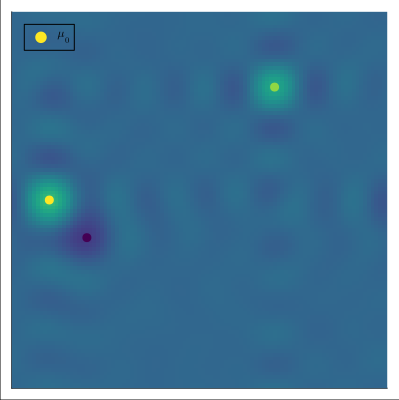

In [29]:
ops = fourier_operators_2D(fc, plt_grids)

y0 = ops.Φ(μ0...)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

heatmap!(plt_obs, hm_grid, hm_grid, ops.adjΦ(y), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", colorscheme=:viridis)

## Pre-certificate

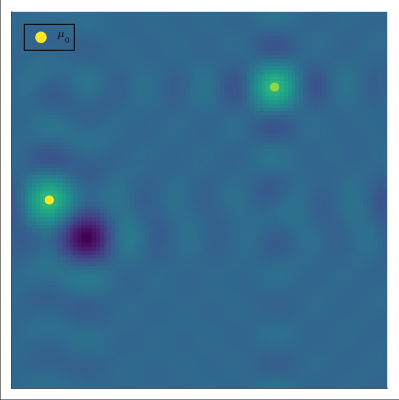

In [85]:
ηV = build_ηV(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, hm_grid, hm_grid, ηV(plt_grids), color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", colorscheme=:viridis)

### SFW

In [31]:
coarse_grids = grid(domain, n_coarse_grid)
λ₀(coarse_grids, ops.ϕ, y, 1e-2)

1.9429422581324405

In [46]:
λ = 0.06

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

BLASSO(ComplexF64[0.03944229919977847 - 0.061769142540341763im, -0.10769049328724037 + 0.08127859239100099im, -0.25016340992633984 - 0.044050578203764845im, -0.030063650599399142 + 0.08651098532717058im, 0.06966409236885678 + 0.34055964691487123im, 0.06814611687784014 + 0.1436377910655411im, 0.2674613735292254 - 0.15253820440816007im, 0.2022974200219672 - 0.09103165020657009im, -0.1489127099088229 - 0.07320333750634986im, -0.10428384121298989 - 0.15773015030990836im  …  -0.10428384121298989 + 0.15773015030990836im, -0.14891270990882294 + 0.07320333750634986im, 0.2022974200219672 + 0.09103165020657009im, 0.2674613735292254 + 0.15253820440816007im, 0.06814611687784014 - 0.1436377910655411im, 0.06966409236885678 - 0.34055964691487123im, -0.03006365059939914 - 0.08651098532717058im, -0.25016340992633984 + 0.044050578203764845im, -0.10769049328724037 - 0.08127859239100098im, 0.03944229919977847 + 0.061769142540341763im], Operators(var"#ϕ#428"{Float64, Int64, UnitRange{Int64}, UnitRange{Int6

In [81]:
prob_sfw = deepcopy(prob)

solve!(prob_sfw, options = Dict(:maxits => 4))

BLASSO(ComplexF64[0.03944229919977847 - 0.061769142540341763im, -0.10769049328724037 + 0.08127859239100099im, -0.25016340992633984 - 0.044050578203764845im, -0.030063650599399142 + 0.08651098532717058im, 0.06966409236885678 + 0.34055964691487123im, 0.06814611687784014 + 0.1436377910655411im, 0.2674613735292254 - 0.15253820440816007im, 0.2022974200219672 - 0.09103165020657009im, -0.1489127099088229 - 0.07320333750634986im, -0.10428384121298989 - 0.15773015030990836im  …  -0.10428384121298989 + 0.15773015030990836im, -0.14891270990882294 + 0.07320333750634986im, 0.2022974200219672 + 0.09103165020657009im, 0.2674613735292254 + 0.15253820440816007im, 0.06814611687784014 - 0.1436377910655411im, 0.06966409236885678 - 0.34055964691487123im, -0.03006365059939914 - 0.08651098532717058im, -0.25016340992633984 + 0.044050578203764845im, -0.10769049328724037 - 0.08127859239100098im, 0.03944229919977847 + 0.061769142540341763im], Operators(var"#ϕ#428"{Float64, Int64, UnitRange{Int64}, UnitRange{Int6

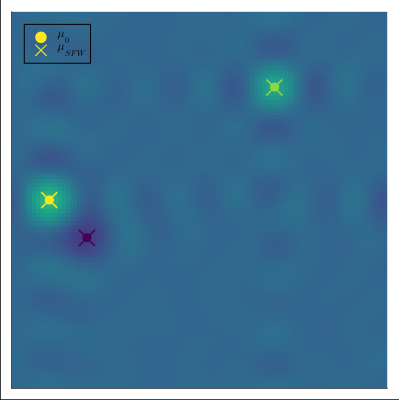

In [84]:
plt_sfw = deepcopy(plt_obs)

plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", colorscheme=:viridis, marker=:x, markersize=8, markerstrokewidth=2)

## Plot $\eta_\lambda$

0.9999992429069748

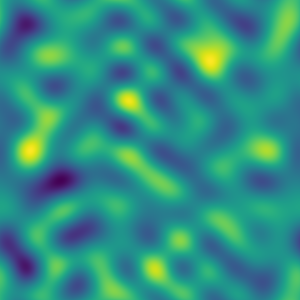

In [ ]:
using Plots.Measures
n_fine_plt_grid = 301

fine_plt_grids = grid(domain, n_fine_plt_grid)
fine_hm_grid = grid(domain[1,:], n_fine_plt_grid)
display(maximum(prob_sfw.η(fine_plt_grids)))
heatmap(fine_hm_grid, fine_hm_grid, prob_sfw.η(fine_plt_grids), color=:viridis, grid=false, ticks=:none, cb=false, size=(300, 300), margins=-2mm)